<a href="https://colab.research.google.com/github/kbcollins/mltdse/blob/main/levenbergmarquardt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax.numpy as jnp
from jax import grad, jacobian, jit, vmap

In [2]:
import numpy as np

In [3]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import scipy.optimize

In [5]:
# suppose we have a function that we're trying to fit
def truef(x):
   return jnp.cos(x)

In [6]:
# we decide to use a polynomial model
# let maxdeg be the maximum degree of the polynomial
maxdeg = 10

# then we assume that theta is of length (maxdeg+1)
# x is a vector of points at which we seek to evaluate the model
def model(theta, x):
    out = jnp.zeros(x.shape)
    for j in range(maxdeg+1):
        out += theta[j]*(x**j)
    
    return out

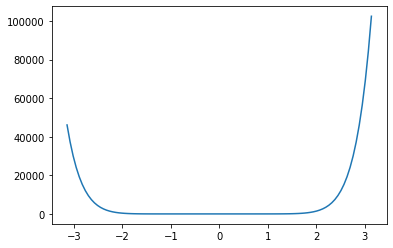

In [7]:
randtheta = np.random.uniform(size=maxdeg+1)
xvec = jnp.linspace(-np.pi,np.pi,101)
test = model(randtheta, xvec)

plt.plot(xvec, test)
plt.show()

In [8]:
# let's sample the true function at the points in xvec
yvec = truef(xvec)

# this is our training data
print(xvec.shape)
print(yvec.shape)

# form our loss function
def loss(theta):
    ypred = model(theta, xvec)
    return 0.5*jnp.sum(jnp.square(ypred - yvec))

jloss = jit(loss)

# loss function at a random theta
print(jloss(randtheta))

# gradient of loss
gradloss = grad(loss)
jgradloss = jit(gradloss)

# Hessian of loss
hessloss = jacobian(gradloss)
jhessloss = jit(hessloss)

(101,)
(101,)
18777550000.0


In [9]:
res = scipy.optimize.minimize(fun=jloss, jac=jgradloss, method='BFGS', 
                              x0=randtheta, options={'disp':True})

         Current function value: 0.000000
         Iterations: 20
         Function evaluations: 124
         Gradient evaluations: 112


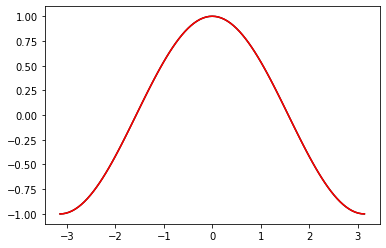

In [10]:
plt.plot(xvec, truef(xvec), color='black')
plt.plot(xvec, model(res.x, xvec), color='red')
plt.show()

In [11]:
# instead of training in this way, we could equall well
# *use* the fact that our loss function is 0.5*sum of squares!
def resid(theta):
    ypred = model(theta, xvec)
    return (ypred - yvec)

In [12]:
jacobresid = jacobian(resid)
jjacob = jit(jacobresid)

In [13]:
# levenberg-marquardt
resls = scipy.optimize.least_squares(fun=resid, jac=jjacob, x0=randtheta, 
                                     method='lm', verbose=2)

`xtol` termination condition is satisfied.
Function evaluations 9, initial cost 1.8778e+10, final cost 1.4672e-11, first-order optimality 6.86e-03.


In [14]:
# how good is this compared to the previously computed solution?
print(jloss(res.x))
print(jloss(resls.x))

2.7150247e-11
1.4702404e-11


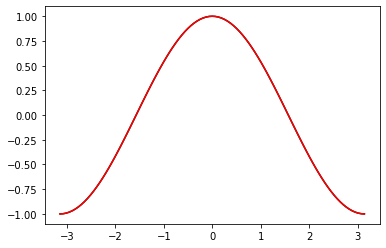

In [15]:
plt.plot(xvec, truef(xvec), color='black')
plt.plot(xvec, model(resls.x, xvec), color='red')
plt.show()

In [16]:
# if you look closely you'll see that we've recovered the Taylor series coeffficients of cosine
print(resls.x)

# compute the true coefficients
truecoeffs = np.zeros(maxdeg+1)
for j in range(maxdeg+1):
    if (j % 2) == 0:
        truecoeffs[j] = (-1)**(j//2) / np.math.factorial(j)

# compute L2 error between optimizer's solution and true Taylor series coefficients
print(np.linalg.norm(resls.x - truecoeffs))

[ 9.99999392e-01  2.31436517e-08 -4.99995258e-01 -6.60866351e-09
  4.16607099e-02 -3.33495470e-09 -1.38615999e-03  8.68239959e-10
  2.42368368e-05 -4.75117479e-11 -2.21143653e-07]
8.130845102979335e-06
